In [53]:
import numpy             as np
import matplotlib.pyplot as plt

from scipy.signal import lfilter

In [54]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

## Create a signal for demonstration.

In [72]:
sample_rate = 48000
nsamples    = 100

freq = [3000, 4000, 8000, 10000, 11000]
Ampl = [1, 2, 3, 2, 1]
Ampl_resc = Ampl/np.sum(Ampl)

t = np.arange(nsamples) / sample_rate

sum = np.zeros_like(t)
for i in range (len(freq)):
    sum = sum + Ampl_resc[i]*np.sin(t*freq[i]*2*np.pi)

x = sum

## Create a FIR filter and apply it to x.

In [88]:
taps = np.array([1915, 5389, 8266, 9979, 8266, 5389, 1915])
taps = np.int16(taps)/2**16
# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

## Save the input and output to txt files

In [89]:
x_stereo     = np.stack((x         , x         ), axis=1)
x_fil_stereo = np.stack((filtered_x, filtered_x), axis=1)
np.savetxt("in_out_file/input_file.txt" , np.int32(x_stereo*2**23)    , fmt='%i')
np.savetxt("in_out_file/output_file.txt", np.int32(x_fil_stereo*2**23), fmt='%i')

filtered_x_FPGA = np.loadtxt("in_out_file/output_file_fir.txt")/2**23

## Plot the FIR filter input and output.

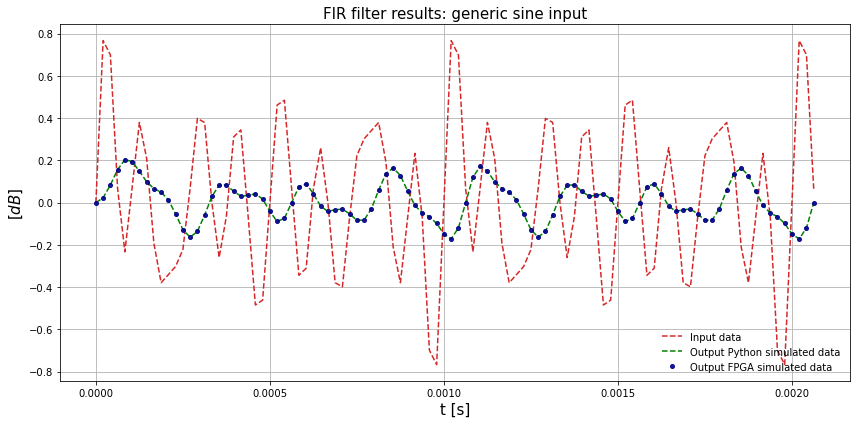

In [90]:
color = 'tab:red'
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel('$[dB]$', fontsize=15)
ax1.set_xlabel('t [s]', fontsize=15)
line1 = ax1.plot(t, x,
                 '--', markersize=1, color=color, label='Input data')
#ax1.set_ylim(5, 24000)
ax1.set_title('FIR filter results: generic sine input', fontsize=15)
ax1.legend(loc='lower left', frameon=False)
ax1.grid(True)


color = 'tab:blue'
line2 = ax1.plot(t, filtered_x,
                 '--', markersize=1, color='green', label='Output Python simulated data')
line3 = ax1.plot(t, filtered_x_FPGA[:,0],
                 'o', markersize=4, color='darkblue', alpha=0.9, label='Output FPGA simulated data')
ax1.legend(loc='lower right', frameon=False)

fig.tight_layout()
#plt.savefig('plots/fft_plot.pdf')
plt.show()

## FFT plot

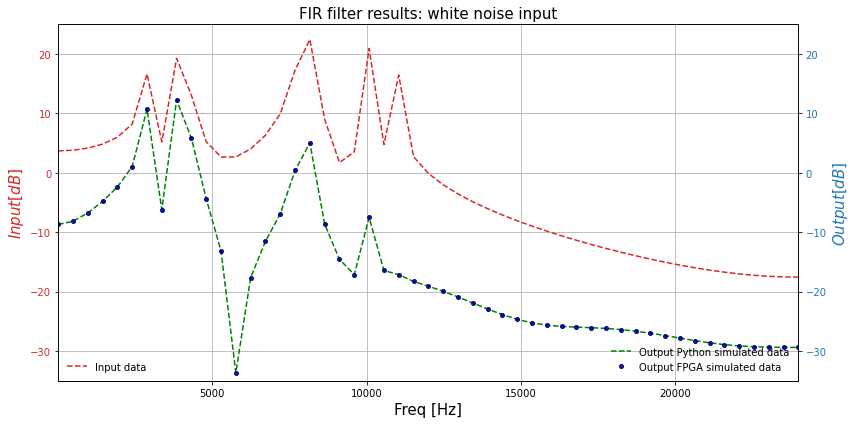

In [91]:
freq_dom = np.linspace(0,sample_rate/2, int(nsamples/2+1), endpoint=True)

fft_unf = np.fft.rfft(x)
fft_fil = np.fft.rfft(filtered_x)
fft_fil_FPGA = np.fft.rfft(filtered_x_FPGA[:,0])


color = 'tab:red'
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel('$Input [dB]$', color=color, fontsize=15)
ax1.set_xlabel('Freq [Hz]', fontsize=15)
line1 = ax1.plot(freq_dom, 20*np.log10(np.abs(fft_unf)),
                 '--', markersize=1, color=color, label='Input data')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim(5, 24000)
ax1.set_title('FIR filter results: white noise input', fontsize=15)
ax1.legend(loc='lower left', frameon=False)
ax1.set_xlim(5,24000)
ax1.set_ylim(-35,25)
ax1.grid(True)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('$Output [dB]$', color=color, fontsize=15)
line2 = ax2.plot(freq_dom, 20*np.log10(np.abs(fft_fil)),
                 '--', markersize=1, color='green', label='Output Python simulated data')
line3 = ax2.plot(freq_dom, 20*np.log10(np.abs(fft_fil_FPGA)),
                 'o', markersize=4, color='darkblue', alpha=0.9, label='Output FPGA simulated data')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right', frameon=False)
ax2.set_ylim(-35,25)

fig.tight_layout()
#plt.savefig('plots/fft_plot.pdf')
plt.show()

## Apply white noise to the filter

In [8]:
x_wn = band_limited_noise(5, 24000, 48000, 48000)
filtered_x_wn = lfilter(taps, 1.0, x_wn)

In [9]:
x_stereo_wn     = np.stack((x_wn         , x_wn         ), axis=1)
x_fil_stereo_wn = np.stack((filtered_x_wn, filtered_x_wn), axis=1)
np.savetxt("in_out_file/input_file_wn.txt" , np.int32(x_stereo_wn*2**23)    , fmt='%i')
np.savetxt("in_out_file/output_file_wn.txt", np.int32(x_fil_stereo_wn*2**23), fmt='%i')

In [15]:
filtered_x_FPGA_wn = np.loadtxt("in_out_file/output_file_fir_wn.txt")/2**23

In [16]:
freq_dom = np.linspace(0,48000/2, int(48000/2+1), endpoint=True)

fft_unf = np.fft.rfft(x_wn)
fft_fil = np.fft.rfft(filtered_x_wn)
fft_fil_FPGA = np.fft.rfft(filtered_x_FPGA_wn[:,0])

<ipython-input-51-c3c13bd2b9e4>:5: RuntimeWarning: divide by zero encountered in log10
  line1 = ax1.plot(freq_dom, 20*np.log10(np.abs(fft_unf)),


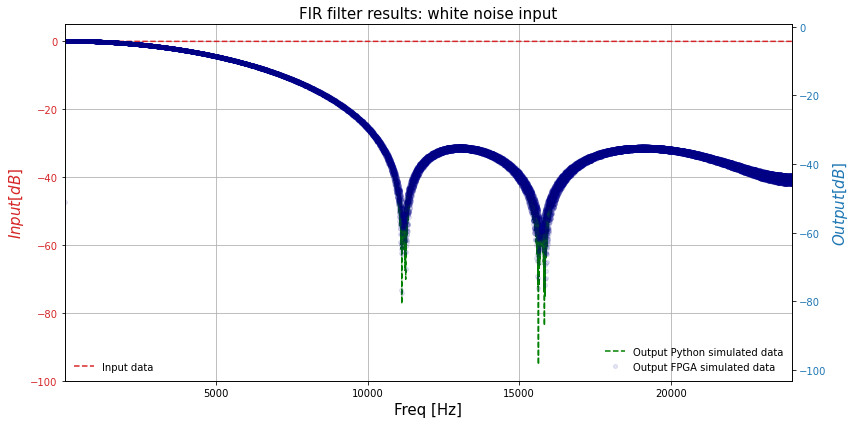

In [51]:
color = 'tab:red'
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel('$Input [dB]$', color=color, fontsize=15)
ax1.set_xlabel('Freq [Hz]', fontsize=15)
line1 = ax1.plot(freq_dom, 20*np.log10(np.abs(fft_unf)),
                 '--', markersize=1, color=color, label='Input data')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim(5, 24000)
ax1.set_title('FIR filter results: white noise input', fontsize=15)
ax1.legend(loc='lower left', frameon=False)
ax1.set_xlim(5,24000)
ax1.set_ylim(-100,5)
ax1.grid(True)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('$Output [dB]$', color=color, fontsize=15)
line2 = ax2.plot(freq_dom, 20*np.log10(np.abs(fft_fil)),
                 '--', markersize=1, color='green', label='Output Python simulated data')
line3 = ax2.plot(freq_dom, 20*np.log10(np.abs(fft_fil_FPGA)),
                 'o', markersize=4, color='darkblue', alpha=0.1, label='Output FPGA simulated data')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right', frameon=False)

fig.tight_layout()
plt.savefig('plots/fft_plot.pdf')
plt.show()

<ipython-input-52-9a813a416b3d>:5: RuntimeWarning: divide by zero encountered in log10
  line1 = ax1.plot(freq_dom, 20*np.log10(np.abs(fft_unf)),


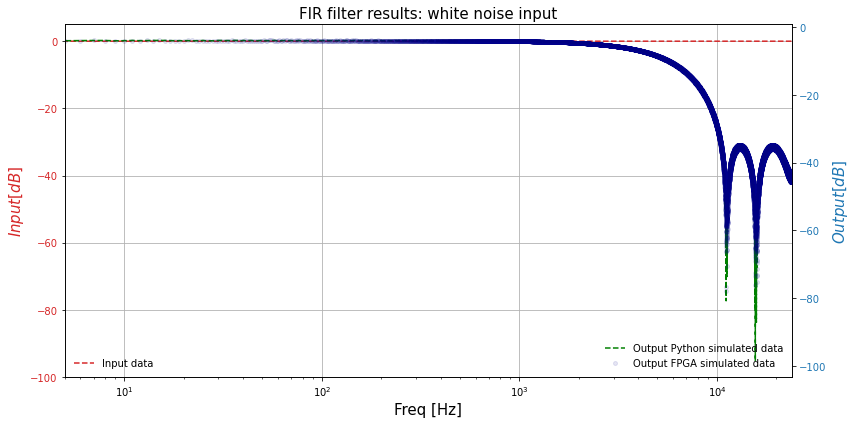

In [52]:
color = 'tab:red'
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel('$Input [dB]$', color=color, fontsize=15)
ax1.set_xlabel('Freq [Hz]', fontsize=15)
line1 = ax1.plot(freq_dom, 20*np.log10(np.abs(fft_unf)),
                 '--', markersize=1, color=color, label='Input data')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim(5, 24000)
ax1.set_title('FIR filter results: white noise input', fontsize=15)
ax1.legend(loc='lower left', frameon=False)
ax1.set_xscale('log')
ax1.set_xlim(5,24000)
ax1.set_ylim(-100,5)
ax1.grid(True)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('$Output [dB]$', color=color, fontsize=15)
line2 = ax2.plot(freq_dom, 20*np.log10(np.abs(fft_fil)),
                 '--', markersize=1, color='green', label='Output Python simulated data')
line3 = ax2.plot(freq_dom, 20*np.log10(np.abs(fft_fil_FPGA)),
                 'o', markersize=4, color='darkblue', alpha=0.1, label='Output FPGA simulated data')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right', frameon=False)

fig.tight_layout()
plt.savefig('plots/fft_plot_log.pdf')
plt.show()